In [177]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
from torchvision.transforms import functional as TF
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, Image as IPImage
from matplotlib.ticker import ScalarFormatter

from wiring_efficiency_utils import *
from neuralsheet import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Example usage
crop_size = 32  # Crop size (NxN)
batch_size = 64  # Number of crops to load at once
num_workers = 4  # Number of threads for data loading
root_dir = './input_stimuli'  # Path to your image folder
device = 'cuda'  # Assuming CUDA is available and desired
M = 64 # Neural sheet dimensions
std_exc = 1 # Standard deviation for excitation Gaussian
std_rfs = 4
epochs = 1

dataloader = create_dataloader(root_dir, crop_size, batch_size, num_workers)
model = NeuralSheet(M, crop_size, std_exc, std_rfs, device=device).to(device)
rf_grids = get_grids(crop_size, crop_size, model.rf_size, M, device=device)

/home/nicolamendini/.local/lib/python3.10/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [7]:
# Looping over the DataLoader

lr = 0

for e in range(epochs):

    model.hebbian_lr = lr
    batch_progress = tqdm(dataloader, leave=False)
    for batch in batch_progress:
        batch = batch.to('cuda')  # Transfer the entire batch to GPU
        for image in batch:
            
            if image.mean()>0.15:

                model(image[None], rf_grids)
                model.hebbian_step()

        mean_activation = model.mean_activations.mean()
        batch_progress.set_description('Mean acts: {:.3f}'.format(mean_activation))

    #decay = 2
    #lr = lr/decay if lr/decay>1e-4 else 5e-5
        

KeyboardInterrupt: 

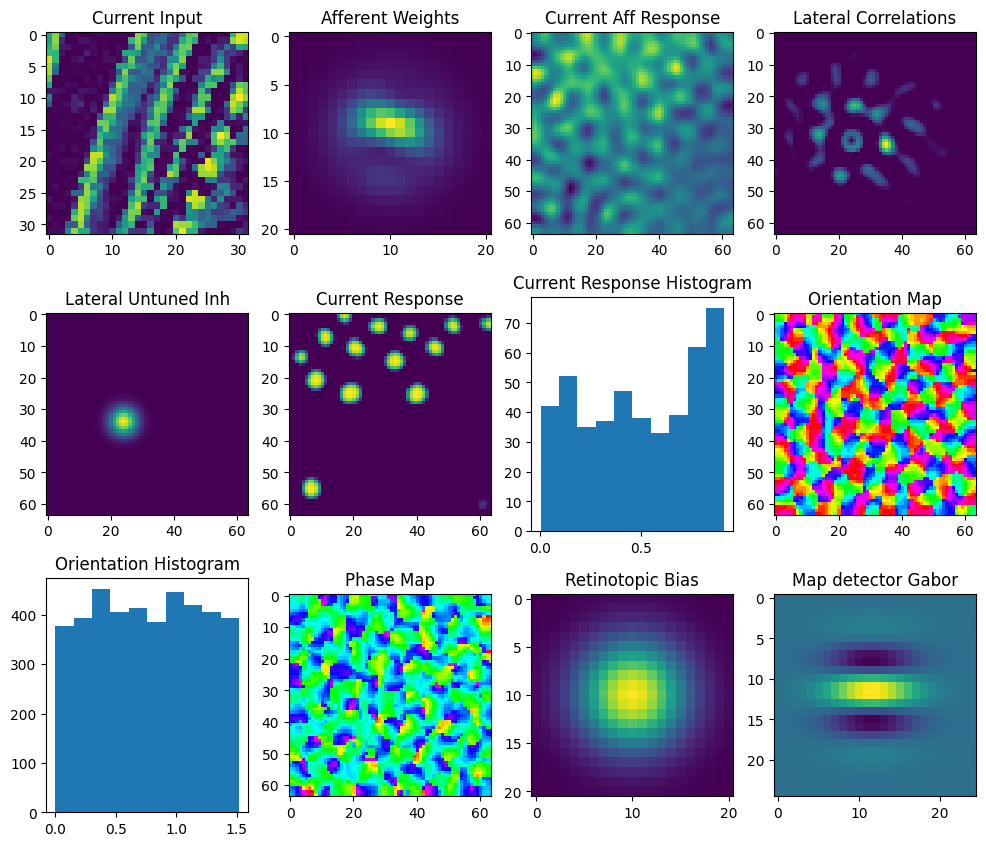

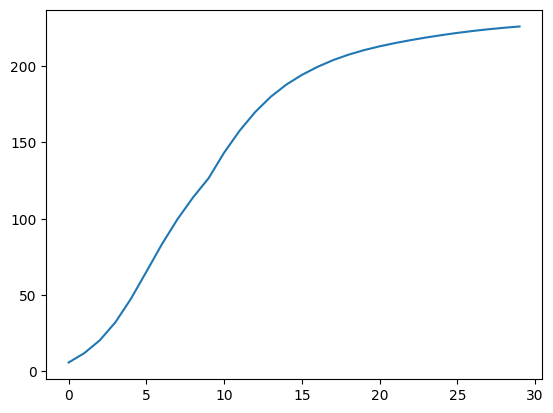

In [230]:
%matplotlib inline

random_sample = 2200 #random.randint(0, model.afferent_weights.shape[0] - 1)
random_batch = random.randint(0, batch.shape[0] - 1)
model(batch[random_batch][None], rf_grids)
show_map(model, random_sample)
model.current_response.max()
array = model.response_tracker.cpu()[:,0]
array[:,0,0] = 1
anim = animate(array, model.iterations)
plt.plot(model.response_tracker[:model.iterations].sum([1,2,3]).cpu())
anim

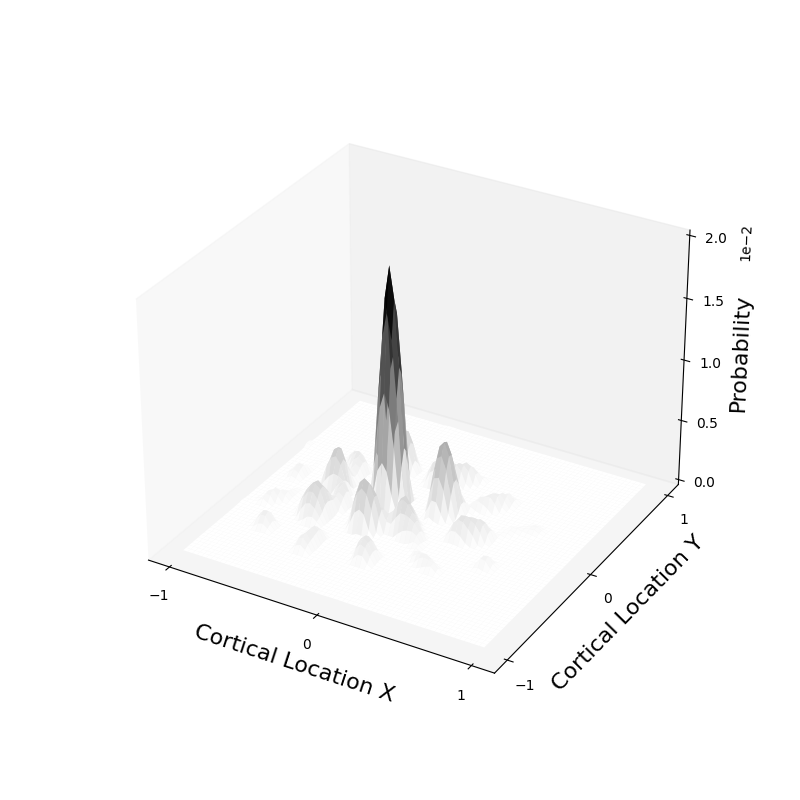

In [231]:
%matplotlib widget

sample = np.random.randint(0, model.sheet_size**2)
sample = 2200
x = np.linspace(-1, 1, M)
y = np.linspace(-1, 1, M)
x, y = np.meshgrid(x, y)
z = model.lateral_correlations[sample,0].cpu() #* model.masks[sample,0].cpu()
#z = z*model.eq + model.untuned_inh[sample,0].cpu()*(1-model.eq)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.grid(False)

ax.set_zlim(0,0.02)

# Customize ticks and labels
ax.set_xticks([-1, 0, 1])
ax.set_yticks([-1, 0, 1])
ax.set_zticks([0, 0.005, 0.01, 0.015, 0.02])
ax.set_xlabel('Cortical Location X', fontsize=16)
ax.set_ylabel('Cortical Location Y', fontsize=16)
ax.set_zlabel('Probability', fontsize=16)

ax.ticklabel_format(style='sci', axis='z', scilimits=(0,0))

ax.plot_surface(x, y, z,  cmap='binary', rstride=1, cstride=1, alpha=1)

plt.show()

/home/nicolamendini/Desktop/cortical-wiring-efficiency-master/wiring_efficiency_utils.py:287: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dist_tensor = torch.tensor(distribution.flatten(), dtype=torch.float)


<Figure size 800x800 with 0 Axes>

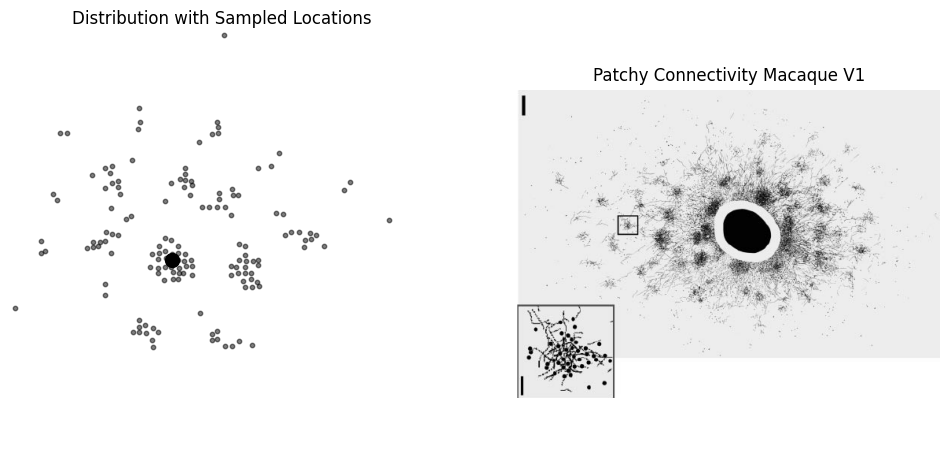

In [117]:
plt.clf()
%matplotlib inline

num_samples = 150   # Number of samples you want to draw
theta = 0

# Assuming model.sheet_size and M are defined elsewhere
# model.sheet_size = ...  
M = model.sheet_size

sample_idx = np.random.randint(0, model.sheet_size**2)
sample_idx = 2200
z = model.lateral_correlations[sample_idx, 0].cpu()

# Generate an example distribution (MxM)
# This could be your actual distribution, ensure it sums to 1 if it represents probabilities
distribution = torch.relu(z - theta)
distribution /= distribution.sum()

sample_and_plot(distribution, num_samples, sample_idx, full=False)

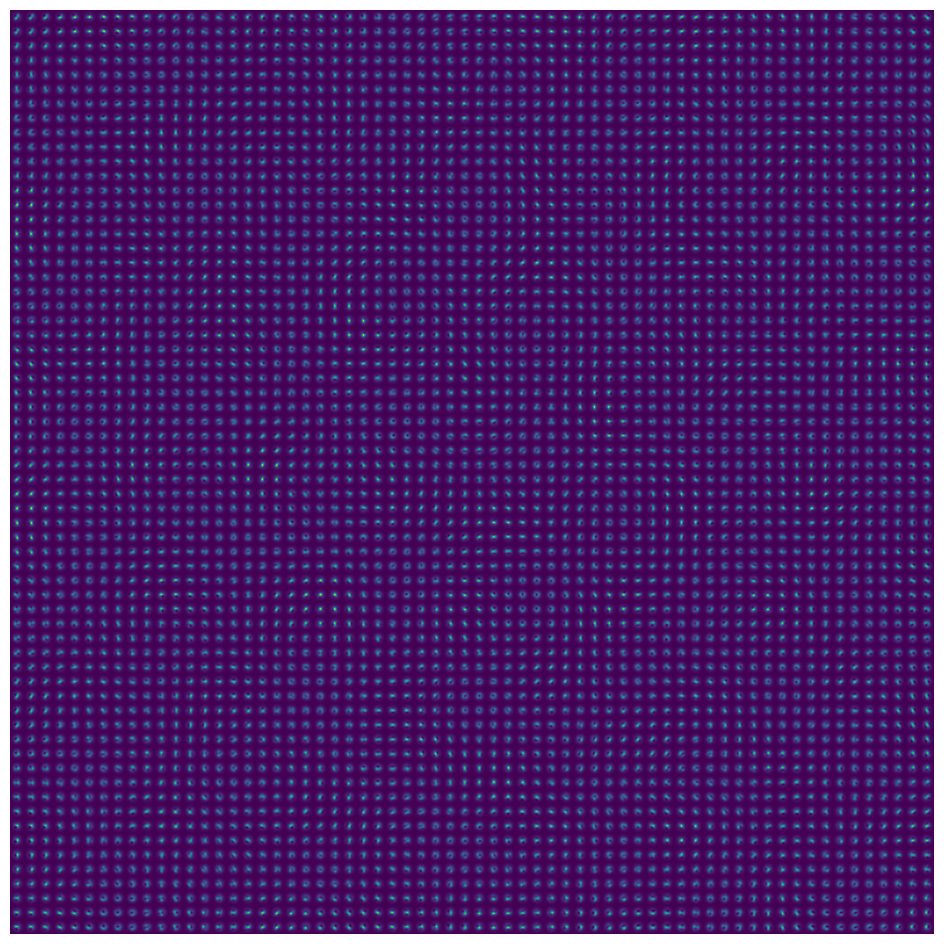

In [468]:
%matplotlib inline
angles = model.afferent_weights.cpu()
angles = angles[:,0].view(M, M, model.rf_size, model.rf_size)
angles = angles.permute(0,2,1,3).reshape(M*model.rf_size, M*model.rf_size)
plt.figure(figsize=(12,12))
plt.axis('off')
plt.imshow(angles)

In [437]:
state = {

    'afferent' : model.afferent_weights,
    'lateral' : model.lateral_correlations
    
}

In [438]:
torch.save(state, 'state.pt')

In [3]:
state = torch.load('std1size64.pt')
model.afferent_weights = state['afferent']
model.lateral_correlations = state['lateral']